<h3><center>GPN Cup Intelligence 2023<h3><center>
<h4><center>Решение кейса по треку Data Science<h4><center>
<h4><center>Трапер Максим<h4><center>

# Содержание
* [1. Загрузка библиотек и данных](#loalib)
* [2. Предобработка данных](#preprocessing)
    * [1. df_competitors (Цены конкурентов)](#pr_df_competitors)
    * [2. df_cost (Себестоимость товаров)](#pr_df_cost)
    * [3. df_transaction (Транзакции нашего магазина)](#pr_df_transaction)
    * [4. df_weather (Данные о погоде)](#pr_df_weather)
* [3. Подготовка к обучению моделей](#preparing_before_learning)
    * [1. Группировка датафреймов по городам, товарам и датам](#gr)
        * [1. df_transaction](#gr_df_tr)
        * [2. df_competitor](#gr_df_comp)
        * [3. df_weather](#gr_df_w)
        * [4. df_cost](#gr_df_cost)
    * [2. Создание одной таблицы фич для обучения моделей](#cr_table_features)
* [4. Предварительная апробация разных предсказательных моделей](#aprob_models_predict)
    * [1. Изучение характеристик временного ряда](#learn_ch_time_ser)
    * [2. Prophet](#prophet)
    * [3. Тройное экспоненциальное сглаживание Холта-Винтерса](#exp_smoothing)
    * [4. AutoArima](#autoarima_m)
    * [5. AutoArima с экзогенными переменными](#autoarima_ex)
* [5. Обучение моделей](#learn_models)

# 1. Загрузка библиотек и данных<a class="anchor" id="loadlib"></a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose

#формат вывода float-чисел в pandas
pd.options.display.float_format = '{:.8f}'.format

In [2]:
df_baseline = pd.read_parquet('df_baseline.parquet')
df_competitors = pd.read_parquet('df_competitors.parquet')
df_cost = pd.read_parquet('df_cost.parquet')
df_transaction = pd.read_parquet('transaction_df.parquet')
df_weather = pd.read_parquet('weather_df.parquet')

In [3]:
df_baseline.sample(5)

,day_num,place,product,price
54,55,Фалькония,Эльфийская пыльца,15.28000000
6,7,Анор Лондо,Целебные травы,13.63000000
70,71,Анор Лондо,Целебные травы,13.63000000
48,49,Врата Балдура,Целебные травы,16.11000000
11,12,Врата Балдура,Эстус,20.33000000


In [4]:
df_competitors.sample(5)

,place,product,competitor,price,date
39290,Фалькония,Эстус,Светлые Души,13.44000000,2218-01-11
13876,Анор Лондо,Эльфийская пыльца,Длань господня,10.20000000,2216-05-28
21108,Нокрон,Эльфийская пыльца,Арториас&Co,8.20000000,2216-01-28
31443,Врата Балдура,Эстус,Светлые Души,16.92000000,2218-04-09
29248,Врата Балдура,Эстус,Арториас&Co,12.87000000,2217-03-18


In [5]:
df_cost.sample(5)

,place,product,cost,date
816,Врата Балдура,Эстус,2.40000000,2216-01-14
507,Кеджистан,Эльфийская пыльца,10.77000000,2217-06-14
79,Врата Балдура,Целебные травы,6.32000000,2217-04-21
715,Фалькония,Эльфийская пыльца,4.24000000,2218-03-14
1109,Фалькония,Эстус,6.90000000,2218-06-20


In [6]:
df_transaction.head(5)

,product,price,amount,place,datetime
0,Целебные травы,3.90000000,1.24212514,Анор Лондо,2216-01-02 16:28:00
1,Целебные травы,3.90000000,-0.07968856,Анор Лондо,2216-01-02 16:21:00
2,Целебные травы,3.90000000,0.88245011,Анор Лондо,2216-01-02 03:03:00
3,Целебные травы,3.90000000,0.62137718,Анор Лондо,2216-01-02 03:12:00
4,Целебные травы,3.90000000,1.36716128,Анор Лондо,2216-01-02 05:33:00


In [7]:
df_weather.sample(5)

,place,hot,rain,snow,date
1602,Врата Балдура,0,0,0,2216-11-17
38,Нокрон,0,0,1,2216-01-09
137,Врата Балдура,1,0,0,2216-01-29
2008,Нокрон,1,0,0,2217-02-06
4615,Фалькония,0,0,0,2218-07-13


Работу нужно будет проводить с временными рядами. Ввиду того, что конечная цель - выставлять цены в рамках нескольких дней, заменим колонки дат со временем на колонки дат типа YY-MM-DD. Необходимо это сделать только для таблицы df_transaction.

In [8]:
# Добавим сначала эту информацию отдельной колонкой
#df_transaction['datetime'] = df_transaction['datetime'].dt.to_period('D')

df_transaction['datetime'] = pd.to_datetime(df_transaction['datetime']).dt.date
#переименуем столбец, чтобы его имя несло правильный смысл
df_transaction.rename(columns={'datetime': 'date'}, inplace=True)
                      
#price = df_transaction.groupby(['YY_MM_DD', 'product', 'place']).agg({'price': ['mean']})

# 2. Предобработка данных<a class="anchor" id="preprocessing"></a>

## 2.1.df_competitors (Цены конкурентов) <a class='anchor' id='pr_df_competitors'></a>

In [9]:
df_competitors.describe(include='all')

,place,product,competitor,price,date
count,31799,31799,31799,31799.00000000,31799
unique,5,3,4,NaN,NaN
top,Анор Лондо,Эстус,ЛилIT,NaN,NaN
freq,6434,10639,8053,NaN,NaN
mean,NaN,NaN,NaN,11.89480990,2217-05-14 12:59:15.281613824
min,NaN,NaN,NaN,2.85000000,2216-01-02 00:00:00
25%,NaN,NaN,NaN,7.78000000,2216-09-07 12:00:00
50%,NaN,NaN,NaN,11.05000000,2217-05-15 00:00:00
75%,NaN,NaN,NaN,15.03000000,2218-01-19 00:00:00
max,NaN,NaN,NaN,31.94000000,2218-09-27 00:00:00


In [10]:
# поменяем название столбца, чтобы не было совпадения с другими столбцами в других таблицах
df_competitors.rename(columns= {'price': 'concurent_price'}, inplace=True)

In [11]:
df_competitors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31799 entries, 0 to 39456
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   place            31799 non-null  object        
 1   product          31799 non-null  object        
 2   competitor       31799 non-null  object        
 3   concurent_price  31799 non-null  float64       
 4   date             31799 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 1.5+ MB


С типами значений и null-значениями всё нормально. 
Минимальные значения численных значений > 0.
Проверим уникальные значения категориальных признаков.

In [12]:
cols = list(df_competitors.select_dtypes(include=['object']).columns.values)

for i in range(len(cols)):
    print(cols[i], ': ', df_competitors[cols[i]].unique())

place :  ['Анор Лондо' 'Врата Балдура' 'Кеджистан' 'Нокрон' 'Фалькония']
product :  ['Целебные травы' 'Эльфийская пыльца' 'Эстус']
competitor :  ['Арториас&Co' 'Длань господня' 'ЛилIT' 'Светлые Души']


## 2.df_cost (Себестоимость товаров) <a class='anchor' id='pr_df_cost'></a>

In [13]:
df_cost.describe(include='all')

,place,product,cost,date
count,1117,1117,1117.00000000,1117
unique,5,3,NaN,NaN
top,Анор Лондо,Эльфийская пыльца,NaN,NaN
freq,226,464,NaN,NaN
mean,NaN,NaN,6.85995524,2217-05-19 20:09:14.341988352
min,NaN,NaN,1.18000000,2216-01-02 00:00:00
25%,NaN,NaN,3.91000000,2216-09-10 00:00:00
50%,NaN,NaN,5.93000000,2217-05-24 00:00:00
75%,NaN,NaN,8.86000000,2218-01-29 00:00:00
max,NaN,NaN,24.52000000,2218-09-27 00:00:00


In [14]:
df_cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117 entries, 0 to 1116
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   place    1117 non-null   object        
 1   product  1117 non-null   object        
 2   cost     1117 non-null   float64       
 3   date     1117 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 35.0+ KB


In [15]:
cols = list(df_cost.select_dtypes(include = ['object']).columns.values)

for i in range(len(cols)):
    print(cols[i], ': ', df_cost[cols[i]].unique())

place :  ['Анор Лондо' 'Врата Балдура' 'Кеджистан' 'Нокрон' 'Фалькония']
product :  ['Целебные травы' 'Эльфийская пыльца' 'Эстус']


In [16]:
# заменим название, чтобы далее не было разночтений
df_cost.rename(columns = {'cost': 'cost_price'}, inplace = True)

In [17]:
#Поставим дату, как индекс
df_cost.index = df_cost['date']
df_cost.drop(['date'], axis=1, inplace=True)

## 3.df_transaction (Транзакции нашего магазина) <a class='anchor' id='pr_df_transaction'></a>

In [18]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875036 entries, 0 to 875035
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   product  875036 non-null  object 
 1   price    875036 non-null  float64
 2   amount   875036 non-null  float64
 3   place    874604 non-null  object 
 4   date     875036 non-null  object 
dtypes: float64(2), object(3)
memory usage: 33.4+ MB


Сразу же замечаем, что тип у даты - object. Меняем.

In [19]:
df_transaction['date'] = pd.to_datetime(df_transaction['date'])

In [20]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875036 entries, 0 to 875035
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   product  875036 non-null  object        
 1   price    875036 non-null  float64       
 2   amount   875036 non-null  float64       
 3   place    874604 non-null  object        
 4   date     875036 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 33.4+ MB


In [21]:
df_transaction.describe(include='all')

,product,price,amount,place,date
count,875036,875036.00000000,875036.00000000,874604,875036
unique,3,NaN,NaN,5,NaN
top,Эстус,NaN,NaN,Фалькония,NaN
freq,303956,NaN,NaN,192527,NaN
mean,NaN,-299.88648179,0.73925907,NaN,2217-05-16 10:28:52.832934912
min,NaN,-9998.99000000,-0.49999973,NaN,2216-01-02 00:00:00
25%,NaN,6.85000000,0.11950821,NaN,2216-09-08 00:00:00
50%,NaN,9.73000000,0.73325741,NaN,2217-05-17 00:00:00
75%,NaN,13.80000000,1.35667379,NaN,2218-01-22 00:00:00
max,NaN,31.20000000,1.99999869,NaN,2218-09-27 00:00:00


Видим очевидные ошибки с отрицательными значениями price и amount. Посмотрим, что они из себя представляют.

In [22]:
print(len(df_transaction[df_transaction['amount'] == 0].axes[0]))
print(len(df_transaction[df_transaction['price'] == 0].axes[0]))

0
0


Нулевые значения отсутствуют.

In [23]:
tr_neg_am = df_transaction[df_transaction['amount'] < 0]
tr_pos_am = df_transaction[df_transaction['amount'] > 0]
tr_neg_am

,product,price,amount,place,date
1,Целебные травы,3.90000000,-0.07968856,Анор Лондо,2216-01-02
14,Целебные травы,3.90000000,-0.02696845,Анор Лондо,2216-01-02
16,Целебные травы,3.90000000,-0.18140015,Анор Лондо,2216-01-02
22,Целебные травы,3.90000000,-0.20938439,Анор Лондо,2216-01-02
27,Целебные травы,3.90000000,-0.30298069,Анор Лондо,2216-01-02
...,...,...,...,...,...
875019,Эстус,9.28000000,-0.13945129,Фалькония,2218-09-27
875021,Эстус,9.28000000,-0.28713263,Фалькония,2218-09-27
875027,Эстус,9.28000000,-0.00629142,Фалькония,2218-09-27
875029,Эстус,9.28000000,-0.18755581,Фалькония,2218-09-27


In [24]:
tr_neg_pr = df_transaction[df_transaction['price'] < 0]
tr_pos_pr = df_transaction[df_transaction['price'] > 0]
tr_neg_pr

,product,price,amount,place,date
5,Целебные травы,-7154.53000000,1.98826457,Анор Лондо,2216-01-02
40,Целебные травы,-8870.90000000,1.70305911,Анор Лондо,2216-01-02
55,Эльфийская пыльца,-1263.59000000,0.02726538,Анор Лондо,2216-01-02
58,Эльфийская пыльца,-1602.39000000,-0.06066367,Анор Лондо,2216-01-02
93,Эльфийская пыльца,-8947.87000000,1.24713461,Анор Лондо,2216-01-02
...,...,...,...,...,...
874988,Эстус,-6154.12000000,1.05371669,Фалькония,2218-09-27
874992,Эстус,-6548.91000000,0.94849785,Фалькония,2218-09-27
875004,Эстус,-1953.21000000,1.53819761,Фалькония,2218-09-27
875014,Эстус,-5824.79000000,-0.20939084,Фалькония,2218-09-27


Отрицательные значения составляют 20% и 6% от всего датасета, соответственно. Следовательно, отрицательные значения - это либо системная ошибка, либо "особые" значения. Рассмотрим, как они соотносяться с остальными - положительными значениями и примем решение, что лучше с ними сделать - дропнуть или просто применить к ним модуль, а возможно что-то другое.

In [25]:
tr_neg_am.describe()

,price,amount,date
count,175559.00000000,175559.00000000,175559
mean,-298.64824281,-0.24990163,2217-05-16 11:39:53.513291776
min,-9998.52000000,-0.49999973,2216-01-02 00:00:00
25%,6.87000000,-0.37452381,2216-09-09 00:00:00
50%,9.78000000,-0.24995171,2217-05-17 00:00:00
75%,13.80000000,-0.12463376,2218-01-21 00:00:00
max,31.20000000,-0.00000297,2218-09-27 00:00:00
std,1404.31215064,0.14455368,NaN


Применим модуль к столбцу amount в датафрейме с отрицательными значениями amount, чтобы можно было сопоставлять значения на графике.

In [26]:
tr_neg_am['amount'] = tr_neg_am['amount'].abs()

In [27]:
rnd_tr_neg_am = tr_neg_am[tr_neg_am['price'] > 0].sample(n = 1000)
rnd_tr_pos_am = tr_pos_am[tr_pos_am['price'] > 0].sample(n = 1000)

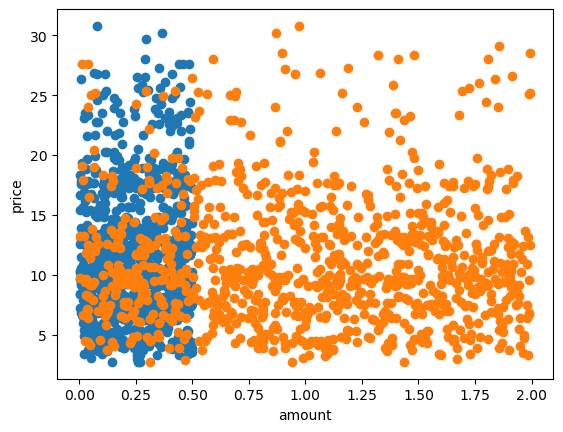

In [28]:
plt.scatter(rnd_tr_neg_am['amount'], rnd_tr_neg_am['price'])
plt.scatter(rnd_tr_pos_am['amount'], rnd_tr_pos_am['price'])
plt.gca().set(xlabel='amount', ylabel='price');

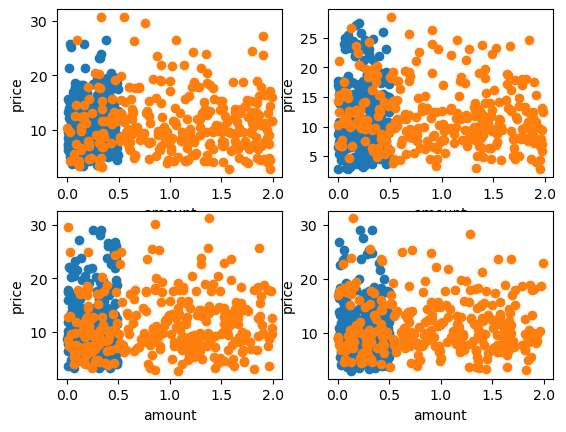

In [29]:
for i in range(4):
    rnd_tr_neg_am = tr_neg_am[tr_neg_am['price'] > 0].sample(n = 300)
    rnd_tr_pos_am = tr_pos_am[tr_pos_am['price'] > 0].sample(n = 300)
    plt.subplot(2, 2, i+1)
    plt.scatter(rnd_tr_neg_am['amount'], rnd_tr_neg_am['price'])
    plt.scatter(rnd_tr_pos_am['amount'], rnd_tr_pos_am['price'])
    plt.gca().set(xlabel='amount', ylabel='price');

Вцелом, зависимость цены от количества в датафрейме с отрицательными значениями соответствует основному датафрейму. Следовательно, можно просто ко всему столбцу amount применить модуль.

In [30]:
df_transaction['amount'] = df_transaction['amount'].abs()

In [31]:
df_transaction[df_transaction['amount'] < 0]

,product,price,amount,place,date


Далее рассмотрим ситуацию с отрицательными ценами.
Вспомним, что по правилам Богов, цены сохраняются, как минимум, в течении нескольких дней. Соответственно, можно просто заполнить все пустые значения - предыдущими известными значениями.

Очевидный минус такого способа заполнения пустых значений - возможная ложная информация, если значение в своём дне стоит последним и далее следует значение следующего дня, в перспективе, с другим значением той же колонки.
В качестве альтернативного метода, можно было бы заменить все "неправильные" значения на нули и при расчёте типичного значения для каждого дня брать медиану или какой-нибудь более высокий квантиль (70%+). Хотя, конечно, это бы всё равно не уберегло нас на 100% от ошибок.

In [32]:
df_transaction['price'] = np.where(df_transaction['price'] < 0, np.nan, df_transaction['price'])

In [33]:
#Замена пустых значений на значения предыдущих строк.
df_transaction['price'].fillna(method='ffill', inplace=True)

In [34]:
df_transaction.describe()

,price,amount,date
count,875036.00000000,875036.00000000,875036
mean,11.41003339,0.83953490,2217-05-16 10:28:52.832934912
min,2.73000000,0.00000055,2216-01-02 00:00:00
25%,7.49000000,0.30822193,2216-09-08 00:00:00
50%,10.00000000,0.73325741,2217-05-17 00:00:00
75%,14.14000000,1.35667379,2218-01-22 00:00:00
max,31.20000000,1.99999869,2218-09-27 00:00:00
std,5.40536050,0.59751551,NaN


In [35]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875036 entries, 0 to 875035
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   product  875036 non-null  object        
 1   price    875036 non-null  float64       
 2   amount   875036 non-null  float64       
 3   place    874604 non-null  object        
 4   date     875036 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 33.4+ MB


Осталось проработать строки с неуказанными городами.
Сделаем так же, как сделали с ценой.

In [36]:
df_transaction[df_transaction.isnull().any(axis=1)]

,product,price,amount,place,date
1411,Целебные травы,3.90000000,0.83455734,None,2216-01-10
4699,Эстус,3.86000000,0.30740881,None,2216-01-31
6428,Эстус,3.89000000,1.23529131,None,2216-02-15
8629,Эстус,4.01000000,0.46830857,None,2216-03-03
11470,Эльфийская пыльца,11.69000000,0.76100219,None,2216-03-22
...,...,...,...,...,...
866797,Эстус,9.56000000,0.62067703,None,2218-08-13
869754,Целебные травы,11.04000000,1.50415702,None,2218-08-31
870093,Целебные травы,11.04000000,0.21736712,None,2218-09-02
871726,Целебные травы,10.97000000,1.58324367,None,2218-09-11


In [37]:
df_transaction['place'].fillna(method='ffill', inplace=True)

In [38]:
df_transaction.describe(include='all')

,product,price,amount,place,date
count,875036,875036.00000000,875036.00000000,875036,875036
unique,3,NaN,NaN,5,NaN
top,Эстус,NaN,NaN,Фалькония,NaN
freq,303956,NaN,NaN,192625,NaN
mean,NaN,11.41003339,0.83953490,NaN,2217-05-16 10:28:52.832934912
min,NaN,2.73000000,0.00000055,NaN,2216-01-02 00:00:00
25%,NaN,7.49000000,0.30822193,NaN,2216-09-08 00:00:00
50%,NaN,10.00000000,0.73325741,NaN,2217-05-17 00:00:00
75%,NaN,14.14000000,1.35667379,NaN,2218-01-22 00:00:00
max,NaN,31.20000000,1.99999869,NaN,2218-09-27 00:00:00


Напоследок, проверим уникальные значения категориальных колонок.

In [39]:
cols = list(df_transaction[['product', 'place']].columns.values)

for i in range(len(cols)):
    print(cols[i], ': ', df_transaction[cols[i]].unique())

product :  ['Целебные травы' 'Эльфийская пыльца' 'Эстус']
place :  ['Анор Лондо' 'Врата Балдура' 'Кеджистан' 'Нокрон' 'Фалькония']


## 4. df_weather (Данные о погоде) <a class='anchor' id='pr_df_weather'></a>

In [40]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   place   5000 non-null   object        
 1   hot     5000 non-null   int64         
 2   rain    5000 non-null   int64         
 3   snow    5000 non-null   int64         
 4   date    5000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 195.4+ KB


In [41]:
df_weather.describe(include='all')

,place,hot,rain,snow,date
count,5000,5000.00000000,5000.00000000,5000.00000000,5000
unique,5,NaN,NaN,NaN,NaN
top,Фалькония,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN
mean,NaN,0.17520000,0.17260000,0.16720000,2217-05-15 12:00:00
min,NaN,0.00000000,0.00000000,0.00000000,2216-01-02 00:00:00
25%,NaN,0.00000000,0.00000000,0.00000000,2216-09-07 18:00:00
50%,NaN,0.00000000,0.00000000,0.00000000,2217-05-15 12:00:00
75%,NaN,0.00000000,0.00000000,0.00000000,2218-01-20 06:00:00
max,NaN,1.00000000,1.00000000,1.00000000,2218-09-27 00:00:00


В данных по погоде выбросов нет.

In [42]:
#Поставим дату, как индекс
df_weather.index = df_weather['date']
df_weather.drop(['date'], axis=1, inplace=True)

# 3. Подготовка к обучению моделей <a class='anchor' id='preparing_before_learning'></a>

## 3.1 Группировка датафреймов по городам, товарам и датам. <a class = 'anchor' id = 'gr'></a>

### 3.1.1 df_transaction <a class='anchor' id = 'gr_df_tr'></a>

In [43]:
#Возьмём списки уникальных значений мест и товаров
places = df_transaction['place'].unique()
products = df_transaction['product'].unique()

In [44]:
def group_by_pl_pr(places, products, need_df):
    # список всех датафреймов
    grouped = []
    
    # первый цикл - иттерация по местам
    for pl in range(len(places)):
        # второй цикл - иттерация по продуктам в каждом месте
        for pr in range(len(products)):
            # составляем название очередного датафрейма в виде "место_продукт"
            cur_place = places[pl]
            cur_prod = products[pr]
            name_df = places[pl] + '_' + products[pr]

            #берём датафрейм по выбранному месту и продукту
            df = need_df[(need_df['place'] == cur_place) & (need_df['product'] == cur_prod)]
            
            # для df_transaction
            if('amount' in df.columns):
                # группировка по дате, где для цены и кол-ва берётся среднее по дню
                df = df[['date', 'price', 'amount']].resample('D', on='date').mean()
                # для Prophet
                df['ds'] = df.index
            # для df_competitors
            elif('concurent_price' in df.columns):
                df = df[['date', 'concurent_price']].resample('D', on='date').mean()
            df.name = name_df
            grouped.append(df)
            
    return grouped

In [45]:
# список всех датафреймов
grouped_transactions = group_by_pl_pr(places, products, df_transaction)

In [46]:
grouped_transactions[0]

,price,amount,ds
date,,,
2216-01-02,3.90000000,0.95775801,2216-01-02
2216-01-03,3.90000000,0.78611897,2216-01-03
2216-01-04,3.90000000,1.00615155,2216-01-04
2216-01-05,3.90000000,0.94650143,2216-01-05
2216-01-06,3.90000000,0.80029318,2216-01-06
...,...,...,...
2218-09-23,13.63000000,0.82401366,2218-09-23
2218-09-24,13.63000000,0.74774156,2218-09-24
2218-09-25,13.63000000,0.75526246,2218-09-25


In [47]:
grouped_transactions[0].describe()

,price,amount,ds
count,1000.00000000,1000.00000000,1000
mean,8.73572564,0.84755690,2217-05-15 12:00:00
min,3.90000000,0.60288669,2216-01-02 00:00:00
25%,7.23000000,0.78991693,2216-09-07 18:00:00
50%,9.06000000,0.84067654,2217-05-15 12:00:00
75%,9.77263592,0.90024631,2218-01-20 06:00:00
max,13.63000000,1.26204890,2218-09-27 00:00:00
std,2.25453466,0.08575941,NaN


### 3.1.2 df_competitors <a class = 'anchor' id = 'gr_df_comp'></a>

In [48]:
grouped_competitors = group_by_pl_pr(places, products, df_competitors)

In [49]:
grouped_competitors[0]

,concurent_price
date,
2216-01-02,4.21000000
2216-01-03,4.04666667
2216-01-04,3.98000000
2216-01-05,3.90333333
2216-01-06,3.98000000
...,...
2218-09-23,7.74500000
2218-09-24,9.34250000
2218-09-25,9.27000000


In [50]:
#есть пустые значения
grouped_competitors[0].describe()

,concurent_price
count,956.00000000
mean,6.53320432
std,1.79015119
min,3.18000000
25%,5.32333333
50%,6.29625000
75%,7.79500000
max,11.34000000


Заполним пустые значения скользящим средним по предыдущим 3-ём дням.

In [51]:
for i in range(len(grouped_competitors)):
    grouped_competitors[i] = grouped_competitors[i].assign(concurent_price = 
                                                               grouped_competitors[i].concurent_price.fillna
                                                                   (grouped_competitors[i].concurent_price.rolling
                                                                            (window = 3,min_periods = 1).mean()))

In [52]:
grouped_competitors[0].describe()

,concurent_price
count,1000.00000000
mean,6.52382042
std,1.77690774
min,3.18000000
25%,5.34125000
50%,6.29250000
75%,7.75958333
max,11.34000000


В итоге, пропуски были убраны, а среднее значение изменилось лишь на 0.01.

### 3.1.3 df_weather <a class='anchor' id = 'gr_df_w'></a>

In [53]:
grouped_weather = []

for pl in range(len(places)):
    #берём датафрейм по выбранному месту
    cur_place = places[pl]
    df = df_weather[(df_weather['place'] == cur_place)]
    df.name = cur_place
    grouped_weather.append(df)

In [54]:
grouped_weather[3]

,place,hot,rain,snow
date,,,,
2216-01-02,Нокрон,0,0,0
2216-01-03,Нокрон,0,0,1
2216-01-04,Нокрон,0,0,1
2216-01-05,Нокрон,0,0,1
2216-01-06,Нокрон,0,0,0
...,...,...,...,...
2218-09-23,Нокрон,0,0,1
2218-09-24,Нокрон,0,0,0
2218-09-25,Нокрон,0,0,1


In [55]:
grouped_weather[3].describe()

,hot,rain,snow
count,1000.00000000,1000.00000000,1000.00000000
mean,0.18200000,0.15600000,0.17500000
std,0.38603760,0.36303691,0.38015723
min,0.00000000,0.00000000,0.00000000
25%,0.00000000,0.00000000,0.00000000
50%,0.00000000,0.00000000,0.00000000
75%,0.00000000,0.00000000,0.00000000
max,1.00000000,1.00000000,1.00000000


### 3.1.4 df_cost <a class = 'anchor' id = 'gr_df_cost'></a>

In [56]:
grouped_cost = group_by_pl_pr(places, products, df_cost)

In [57]:
grouped_cost[4]

,place,product,cost_price
date,,,
2216-01-02,Врата Балдура,Эльфийская пыльца,5.92000000
2216-01-18,Врата Балдура,Эльфийская пыльца,6.98000000
2216-02-01,Врата Балдура,Эльфийская пыльца,5.06000000
2216-02-06,Врата Балдура,Эльфийская пыльца,9.72000000
2216-02-21,Врата Балдура,Эльфийская пыльца,8.38000000
...,...,...,...
2218-08-24,Врата Балдура,Эльфийская пыльца,12.40000000
2218-09-07,Врата Балдура,Эльфийская пыльца,19.62000000
2218-09-14,Врата Балдура,Эльфийская пыльца,13.33000000


## 3.2 Создание таблиц фич для обучения модели <a class = 'anchor' id = 'cr_table_features'></a>

Для начала создадим таблицу экзогенных переменных.

Включим в неё все переменные из других датафреймов (не с транзакциями).
Amount, по моему мнению, экзогенной переменной не является, т.к количество купленного товара идёт уже как следствие поставленной цены (высокая цена - маленькие продажи, низкая цена - большие продажи). А вот при предсказании самого Amount`а, цена уже может являться эндогенной переменной.

In [58]:
#делаем копии каждого датафрейма, чтобы наш новый список не был ссылкой на копируемые датафреймы
exog = []
for i in range(len(grouped_competitors)):
    exog.append(grouped_competitors[i].copy())

In [59]:
for i in range(len(exog)):
    exog[i] = exog[i].merge(grouped_cost[i]['cost_price'], on = 'date', how = 'left')
    #целочисленное деление на 3 используется, т.к. погода у нас лишь по городам. Порядок городов во всех группированных списках совпадает
    exog[i] = exog[i].merge(grouped_weather[i//3][['hot', 'rain', 'snow']], on = 'date', how = 'left')

In [60]:
# убираем пропуски в себестоимости, путём взятия предыдущего известного значения, т.к. считаем, что себестоимость является актуальной 
# до появления новой
for i in range(len(exog)):
    exog[i]['cost_price'].fillna(method='ffill', inplace=True)

In [61]:
exog[4]

,concurent_price,cost_price,hot,rain,snow
date,,,,,
2216-01-02,12.23000000,5.92000000,0,0,1
2216-01-03,14.15000000,5.92000000,0,0,1
2216-01-04,13.04500000,5.92000000,0,1,0
2216-01-05,14.13000000,5.92000000,1,0,0
2216-01-06,13.58750000,5.92000000,0,0,1
...,...,...,...,...,...
2218-09-23,24.75000000,17.69000000,0,0,0
2218-09-24,26.28000000,17.69000000,0,0,1
2218-09-25,25.76000000,17.69000000,0,0,0


# 4. Предварительная апробация разных предсказательных моделей. <a class = 'anchor' id = 'aprob_models_predict'></a>

Опробуем разные методы прогнозирования на 1 из 15 датафреймов сгруппированных транзакций, чтобы выбрать модель, выдающую наилучшее качество и масштабировать её использование на все транзакции.

In [62]:
import prophet

In [63]:
# заводим переменную с кол-вом дней для предсказания
predictions = 90

train_price = []
test_price = []

train_amount = []
test_amount = []

# разделим df сгруппированных транзакций на train test
for i in range (len(grouped_transactions)):
    #кол-во строк в df[i]
    len_gr_tr = len(grouped_transactions[i].axes[0])
    train_price.append(pd.DataFrame(grouped_transactions[i][0:len_gr_tr - predictions][['price', 'ds']]))
    test_price.append(pd.DataFrame(grouped_transactions[i][len_gr_tr - predictions: len_gr_tr][['price', 'ds']]))
                      
    train_amount.append(pd.DataFrame(grouped_transactions[i][0:len_gr_tr - predictions][['price', 'ds']]))
    test_amount.append(pd.DataFrame(grouped_transactions[i][len_gr_tr - predictions: len_gr_tr][['price', 'ds']]))
    
    #переименовываем для Prophet
    train_price[i].rename(columns = {'price': 'y'}, inplace=True)
    test_price[i].rename(columns = {'price': 'y'}, inplace=True)
    train_amount[i].rename(columns = {'price': 'y'}, inplace=True)
    test_amount[i].rename(columns = {'price': 'y'}, inplace=True)

exog_train = []
exog_test = []    
    
for i in range(len(exog)):
    exog_train.append(pd.DataFrame(exog[i][0:len(exog[i].axes[0]) - predictions]))
    exog_test.append(pd.DataFrame(exog[i][len(exog[i].axes[0]) - predictions: len(exog[i].axes[0])]))

In [64]:
print(len(train_amount[0]))
print(len(test_amount[0]))

910
90


In [65]:
from sklearn.metrics import mean_absolute_percentage_error

#функция вывода графиков предсказанного и метрики предсказанного по MAPE
def cmp_real_predicted(predicted, train, test):
    plt.figure(figsize=(13,5))
    
    if('yhat' in predicted.columns):
        ax = sns.lineplot(data = predicted, x = predicted['ds'], y = predicted['yhat'], label = 'predicted')
    else:
        ax = sns.lineplot(data = predicted, label = 'predicted')
        
    ax = sns.lineplot(data = train, x = train['ds'], y = train['y'], label = 'train')
    ax = sns.lineplot(data = test, x = test['ds'], y = test['y'], label = 'test')
    
    ax.set (xlabel='date', ylabel='price')
    plt.show()
    
    #для Prophet
    if('yhat' in predicted.columns):
        print('Точность предсказания train ряда по MAPE = ' + str(mean_absolute_percentage_error
                  (predicted[0: len(predicted.axes[0]) - 90]['yhat'], 
                       train['y'])))
        print('Точность предсказания test ряда по MAPE = ' + str(mean_absolute_percentage_error
                  (predicted[len(predicted.axes[0]) - 90: len(predicted.axes[0])]['yhat'], 
                       test['y'])))
    
    #для эксп.сглаж
    elif(len(predicted) > predictions):
        print('Точность предсказания train ряда по MAPE = ' + str(mean_absolute_percentage_error
              (predicted[0: len(fitted_exp_model.axes[0]) - 90], 
                   train['y'])))
        print('Точность предсказания test ряда по MAPE = ' + str(mean_absolute_percentage_error
              (predicted[len(fitted_exp_model.axes[0]) - 90: len(fitted_exp_model.axes[0])], 
                   test['y'])))
    
    #для AutoArima
    else:
        print('Точность предсказания test ряда по MAPE = ' + str(mean_absolute_percentage_error
              (predicted, 
                   test['y'])))

## 4.1 Изучение характеристик временного ряда <a class = 'anchor' id = 'learn_ch_time_ser'></a>

In [66]:
from statsmodels.tsa.seasonal import STL

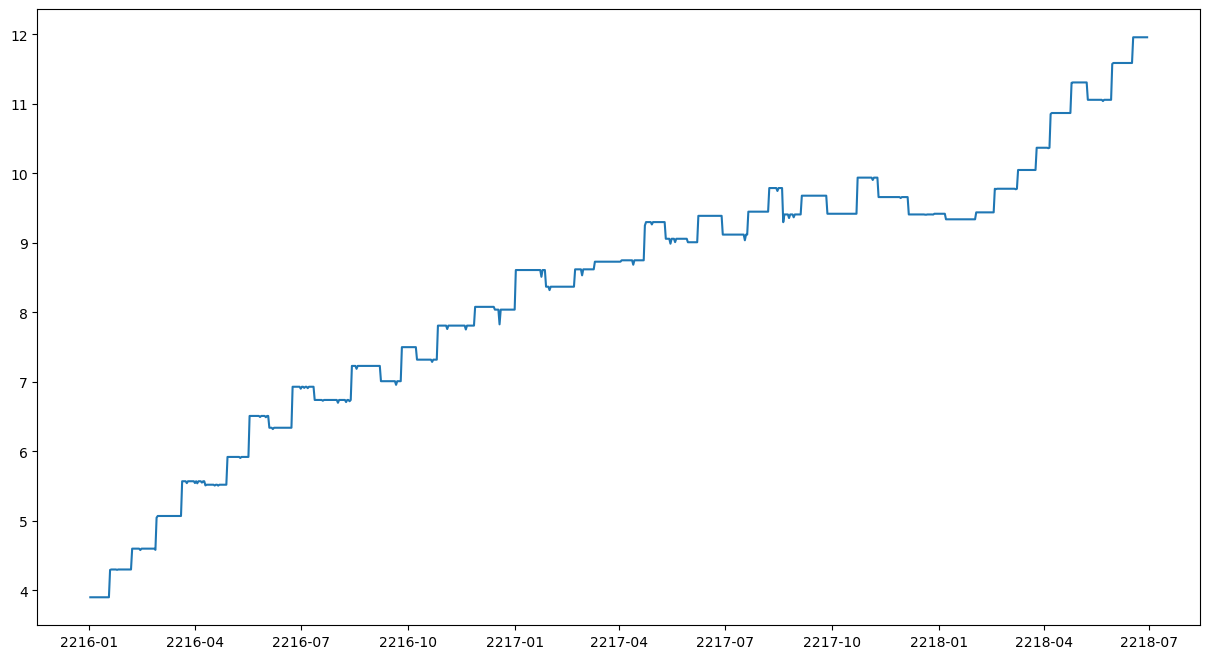

In [67]:
plt.figure(figsize=(15, 8))
ax = plt.plot(train_price[0]['y']);

Выбросов не наблюдается.

Восходящий тренд сразу же угадывается. По поводу сезонности трудно сказать, нужно посмотреть ещё. Но, предварительно, предполагаю наличие недельной аддитивной сезонности.

<Figure size 1500x800 with 0 Axes>

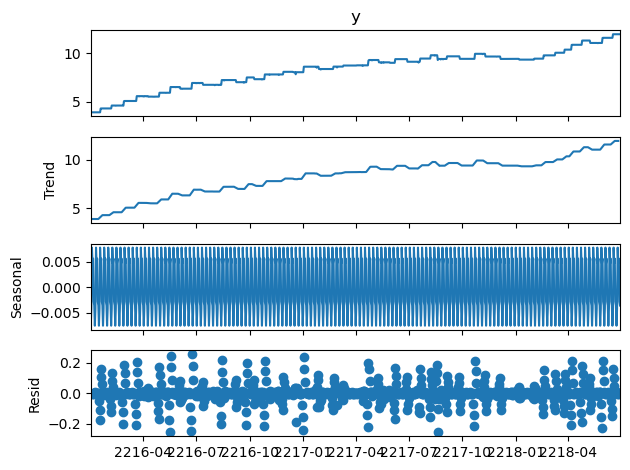

In [68]:
plt.figure(figsize=(15, 8))
decompose = seasonal_decompose(train_price[0]['y'], model='additive', period=7)
decompose.plot();

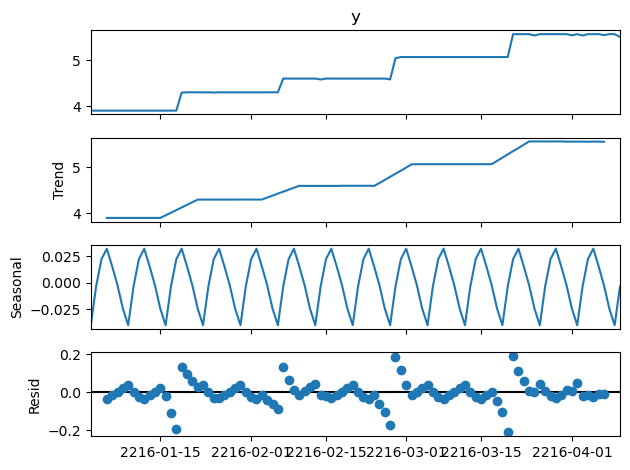

In [69]:
seasonal_decompose(train_price[0][0:100]['y']).plot();

Недельная сезонность всё-таки присутствует. Посмотрим, что насчёт годовой.

In [70]:
months_train_price = grouped_transactions[0]['price'].copy()
months_train_price = months_train_price.resample('M').mean()

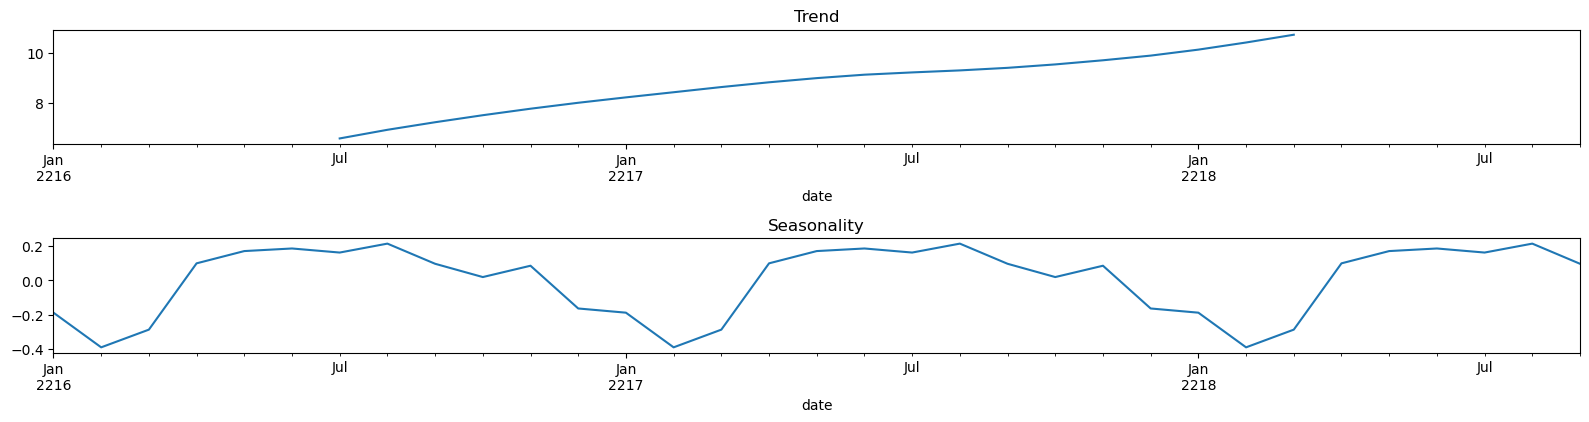

In [71]:
plt.figure(figsize=(16, 10))
ax = seasonal_decompose(months_train_price);
plt.subplot(511)
ax.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(512)
ax.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

Есть наличие годовой сезонности, когда в тёплые времена года, цена либо растёт, либо находится в своём максимуме, зато к осени она начинает снижаться и к зиме достигает глобального минимума.

In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

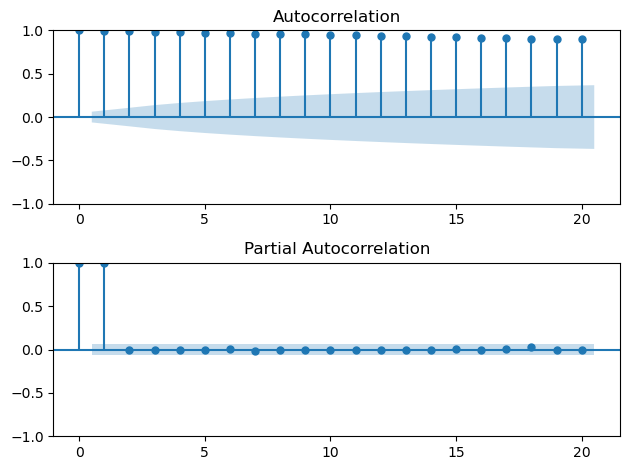

In [73]:
plt.figure()
plt.subplot(211)
plot_acf(grouped_transactions[0]['price'], lags = 20, ax=plt.gca())

plt.subplot(212)
plot_pacf(grouped_transactions[0]['price'], method='ywmle', lags = 20, ax=plt.gca())
plt.tight_layout()
plt.show()

Идёт очень медленное убывание. Попробуем продиффиринцировать с периодом = 1.

In [74]:
#отбрасываем первой, т.к. оно = NaN
diff_tr = grouped_transactions[0]['price'].diff(periods=1)[1:]

In [75]:
diff_tr

date
2216-01-03   -0.00000000
2216-01-04    0.00000000
2216-01-05   -0.00000000
2216-01-06    0.00000000
2216-01-07   -0.00000000
                 ...    
2218-09-23    0.12291667
2218-09-24    0.00000000
2218-09-25    0.00000000
2218-09-26    0.00000000
2218-09-27    0.00000000
Freq: D, Name: price, Length: 999, dtype: float64

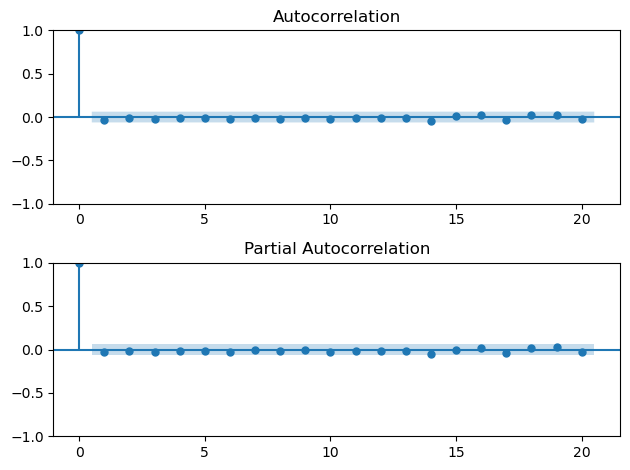

In [76]:
plt.figure()
plt.subplot(211)
plot_acf(diff_tr, lags = 20, ax=plt.gca())

plt.subplot(212)
plot_pacf(diff_tr, method='ywmle', lags = 20, ax=plt.gca())
plt.tight_layout()
plt.show()

Получаем, что все автокорелляции = 0, остатки больше не несут за собой информации. Т.е. ряд - случайно блуждающий. Значит, можно взять ARIMA(0, 1, 0), исходя из гербария по ACF/PACF.

## 4.2 Prophet <a class = 'anchor' id = 'prophet'></a>

Библиотека как раз предназначена больше для дневного прогнозирования, поэтому попробуем её.

Строим модель с недельной и годовой сезонностями аддитивного типа. Используем кусочно-линейную регрессию для описания тренда.

In [77]:
prophet_model = prophet.Prophet(yearly_seasonality = True, weekly_seasonality=True, seasonality_mode='additive',
                                growth = 'linear')
prophet_model.fit(train_price[0]);

05:34:15 - cmdstanpy - INFO - Chain [1] start processing
05:34:15 - cmdstanpy - INFO - Chain [1] done processing


In [78]:
future = prophet_model.make_future_dataframe(periods = predictions, freq = 'd')
forecast = prophet_model.predict(future);

In [79]:
predicted = forecast[['ds', 'yhat']]

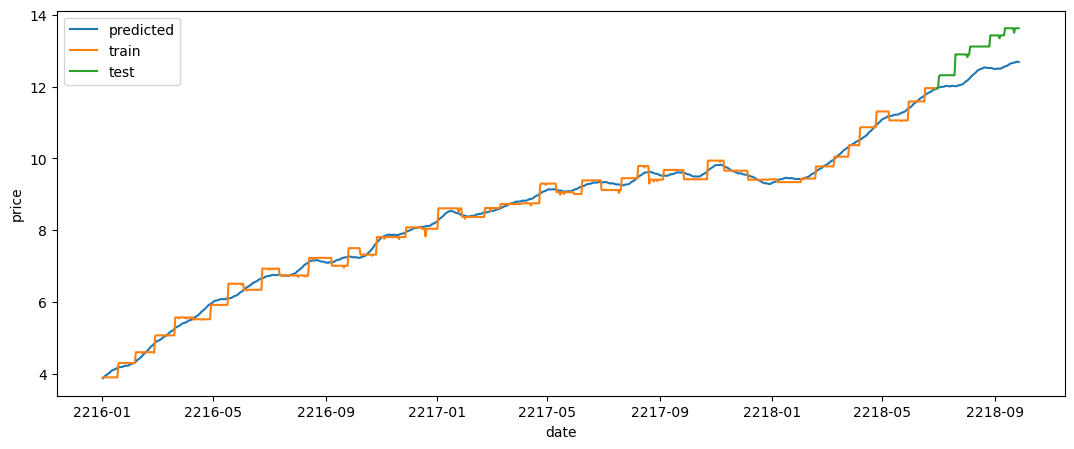

Точность предсказания train ряда по MAPE = 0.016455508945709765
Точность предсказания test ряда по MAPE = 0.05699865423201712


In [80]:
cmp_real_predicted(predicted, train_price[0], test_price[0])

Модель сохранила в себе возрастающий тренд, но не настолько сильный, как в тестовых данных. Также модель не уловила характерную особенность, что цена сохраняет одно и тоже значение на протяжении нескольких дней.

Посмотрим на внутрибиблиотечные графики сезонности и тренда.

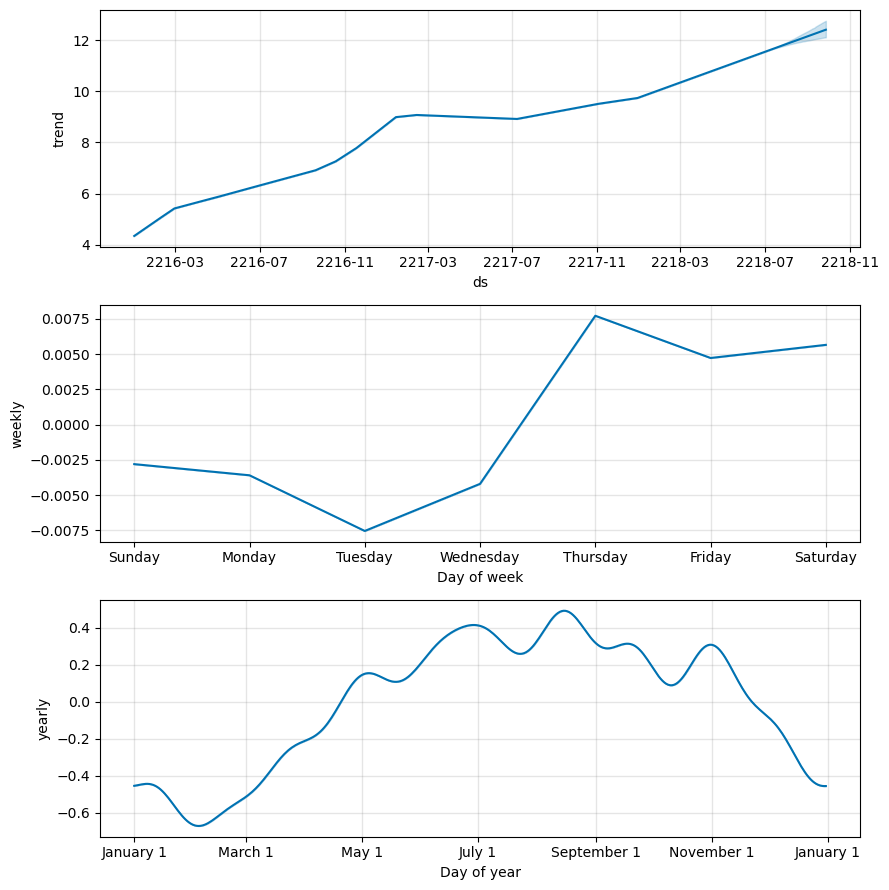

In [81]:
prophet_model.plot_components(fcst = forecast);

Вцелом, мы видим всё то, о чем говорилось ранее, когда анализировались графики.

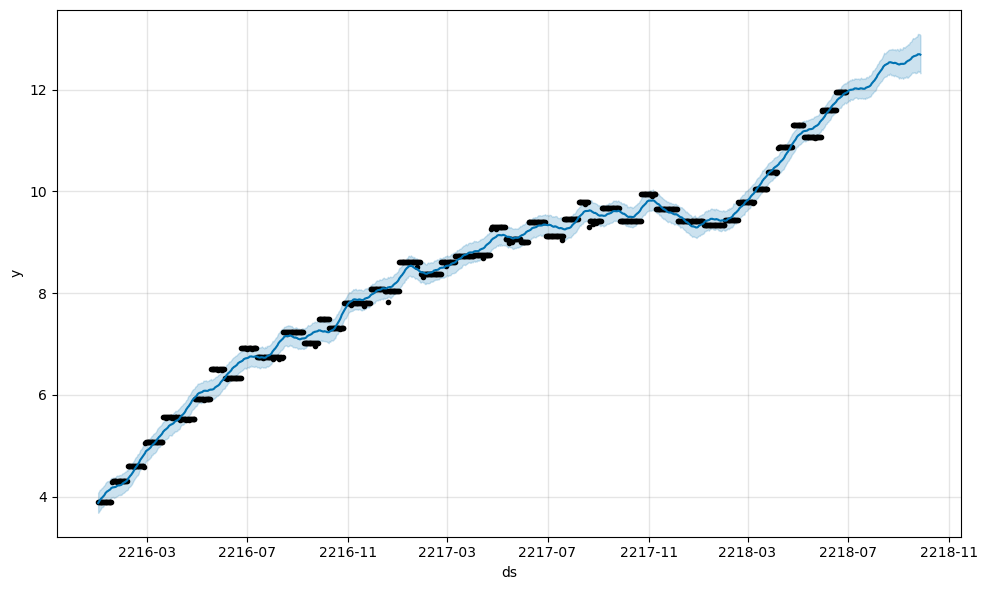

In [82]:
prophet_model.plot(forecast);

## 4.3 Тройное экспоненциальное сглаживание Холта-Винтерса <a class = 'anchor' id = 'exp_smoothing'></a>

In [83]:
from statsmodels.tsa.api import ExponentialSmoothing

In [84]:
exp_model = ExponentialSmoothing(train_price[0][['y']], seasonal_periods=7, trend='additive', seasonal='additive', damped = True).fit()

In [85]:
fitted_exp_model = pd.DataFrame(exp_model.predict(0, len(train_price[0].axes[0]) + predictions - 1))

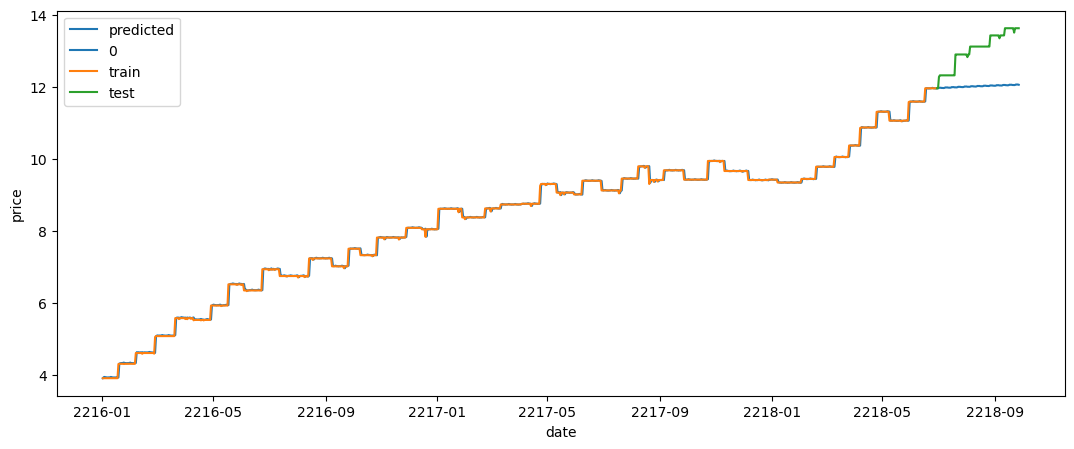

Точность предсказания train ряда по MAPE = 0.003469305995037068
Точность предсказания test ряда по MAPE = 0.0848966326998273


In [86]:
cmp_real_predicted(fitted_exp_model, train_price[0], test_price[0])

Модель очень точно описала обучающие данные, но на тесте показала себя очень неважно. Почему-то тренд из возрастающего почти полностью перешёл в боковой.

### 4.4 AUTOARIMA <a class ='anchor' id = 'autoarima_m'></a>

In [87]:
import pmdarima as pm
from statsmodels. tsa.stattools import adfuller

Модель ARIMA требует того, чтобы на вход подавался стационарный ряд. Воспользуемся тестом Дики-Фуллера для проверки стационарности ряда.

In [88]:
adfuller(train_price[0]['y'])

(-1.3174854137439025,
 0.6211352353768559,
 0,
 909,
 {'1%': -3.4375643702748078,
  '5%': -2.8647248254388096,
  '10%': -2.568465808810804},
 -1955.6906036176124)

P-value = 0.62, что >, чем уровень значимости = 0.05 => нулевая гипотеза не отвергается и ряд нестационарен.

Прологарифмируем ряд, в попытке добится стабилизации дисперсии и стационарности ряда.

In [89]:
#сделаем ряд стационарным, путём логарифмирования
log_train_price = np.log10(train_price[0]['y'])

In [90]:
adfuller(log_train_price)

(-2.8710188740532305,
 0.04882339299605929,
 0,
 909,
 {'1%': -3.4375643702748078,
  '5%': -2.8647248254388096,
  '10%': -2.568465808810804},
 -7042.452238539914)

Это помогло сделать ряд стационарным.

Отобразим ряд на графике.

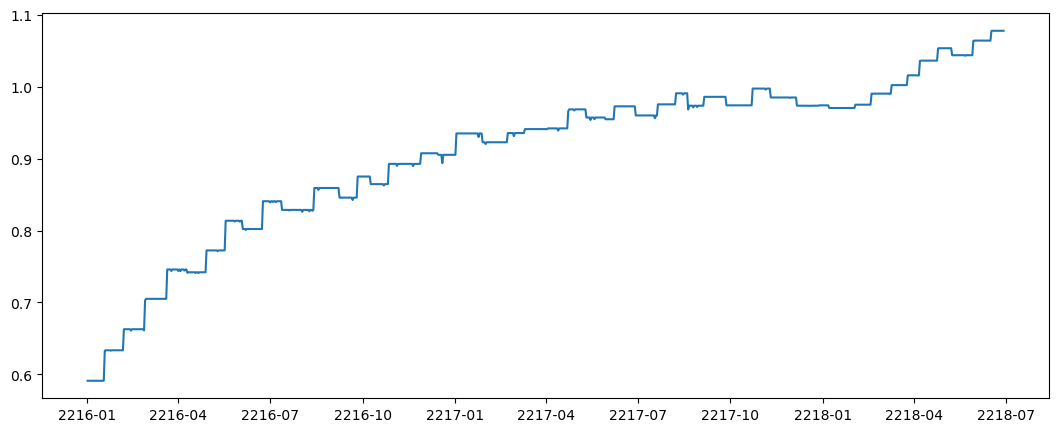

In [91]:
plt.figure(figsize = (13, 5))
plt.plot(log_train_price)

При визуальном сравнении нужно скрупулёзно присматриваться, чтобы найти изменения в характере поведения рядов.

Построим модель с недельной сезонностью.

In [92]:
model_autoarima = pm.auto_arima(log_train_price, m=7, seasonal=True, with_intercept=True)

In [93]:
model_autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  910
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3574.346
Date:                Sun, 12 Nov 2023   AIC                          -7144.693
Time:                        05:34:24   BIC                          -7135.068
Sample:                    01-02-2216   HQIC                         -7141.018
                         - 06-29-2218                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.934      0.053   -7.29e-06       0.001
sigma2      2.249e-05   4.09e-07     55.042      0.000    2.17e-05    2.33e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):             62730.33
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                             5.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Можем убедиться, что автоматический метод подобрал такие же параметры p, d, q (0, 1, 0), как и мы, при анализе ряда.

In [94]:
model_autoarima.fit(log_train_price)

forecast2 = model_autoarima.predict(n_periods=predictions)

In [95]:
#вернём значения в правильное представление
for i in range(len(forecast2)):
    forecast2[i] = 10**forecast2[i]

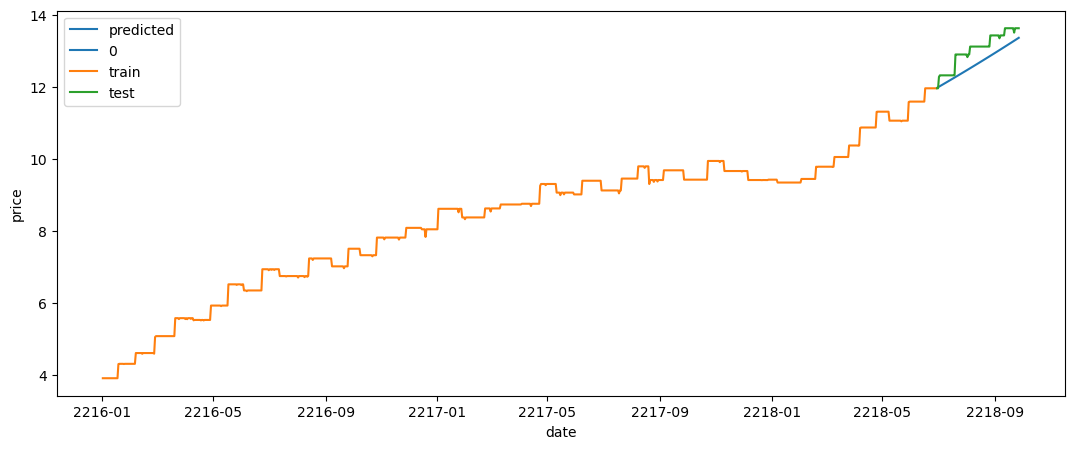

Точность предсказания test ряда по MAPE = 0.03008569827113406


In [96]:
cmp_real_predicted(pd.DataFrame(forecast2), train_price[0], test_price[0])

Модель SARIMA лучше всех из трёх представленных показала себя на предсказании. Был взят лучший (наиболее приближенный) по своему росту тренд, хотя "ступенчатый" характер всё равно не был угадан (однако, при сравнении с этим предсказанием, хочется поставить + библиотеке Prophet, т.к. она хоть и сгладила график, но он был нелинейный, как здесь).

## 4.5 AutoArima с экзогенными переменными <a class = 'anchor' id ='autoarima_ex'></a>

Попробуем AutoArima со всеми нам экзогенными переменными (себестоимость товаров, цена у конкурентов, погода)

In [97]:
model_autoarima2 = pm.auto_arima(log_train_price, m=7, seasonal=True, X = exog_train[0])

In [98]:
model_autoarima2.fit(log_train_price, X = exog_train[0])

forecast3 = model_autoarima2.predict(n_periods=predictions, X = exog_test[0])

for i in range(len(forecast3)):
    forecast3[i] = 10**forecast3[i]

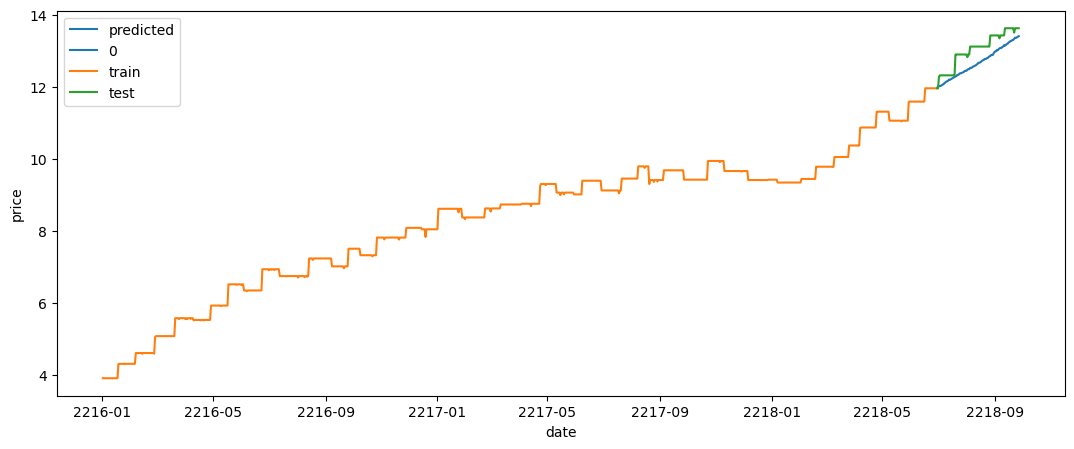

Точность предсказания test ряда по MAPE = 0.028822935966153703


In [99]:
cmp_real_predicted(pd.DataFrame(forecast3), train_price[0], test_price[0])

In [100]:
print(f'Качество с применением эндогенных переменных улучшилось на {0.03008569827113406 - 0.028822935966102907}, что является очень скромным результатом. Тем не менее, это помогло.')

Качество с применением эндогенных переменных улучшилось на 0.0012627623050311537, что является очень скромным результатом. Тем не менее, это помогло.


Попробуем посмотреть, что будет, если из ряда эндогенных переменных исключить погоду, т.к. я не знаю, как её можно прогнозировать. Возможно стоило бы попробовать анализ множественного соответствия (MCA на одну компоненту) и регрессией сделать predict. (погода в нашем датасете - категориальная переменная, обработанная OneHotEncoding`ом). 

Также можно было бы попробовать использовать XGBoost

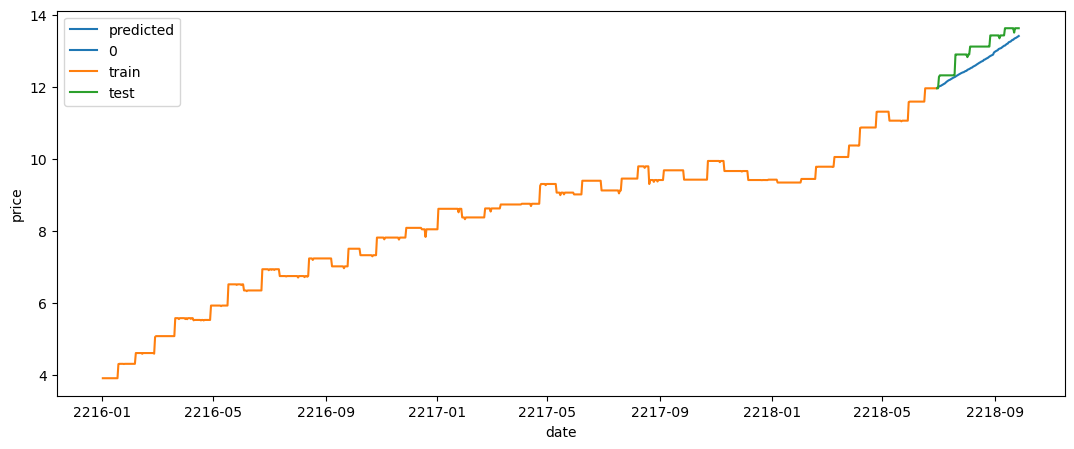

Точность предсказания test ряда по MAPE = 0.029071075971888675


In [101]:
model_autoarima3 = pm.auto_arima(log_train_price, m=7, seasonal=True, X = exog_train[0][['concurent_price', 'cost_price']])
model_autoarima3.fit(log_train_price, X = exog_train[0][['concurent_price', 'cost_price']])

forecast4 = model_autoarima3.predict(n_periods=predictions, X = exog_test[0][['concurent_price', 'cost_price']])

for i in range(len(forecast4)):
    forecast4[i] = 10**forecast4[i]
    
cmp_real_predicted(pd.DataFrame(forecast4), train_price[0], test_price[0])

In [102]:
print(f'Качество с применением эндогенных переменных, исключая погоду, улучшилось на {0.03008569827113406 - 0.029071075971888675}')

Качество с применением эндогенных переменных, исключая погоду, улучшилось на 0.0010146222992453852


Относительно общего вклада в успешность прогноза, среди эндогенных переменных, погода вносит не очень большой вклад (около 16%).

Однако, даже убирая погоду из эндогенных переменных, встаёт вопрос, стоит ли использовать оставшиеся переменные (стоимость у конкурентов и себестоимость товаров)? Ведь для дальнейшего прогноза, нам нужно будет прогнозировать и их. А это, как мне кажется, может нести в себе ложную информацию. 

Хотя, с другой стороны, это довольно обыденная задача множественного прогнозирования рядов. + задача стоит вывести выручку за предсказанные 90 дней, а значит amount и себестоимости, как минимум, придётся предсказывать.

## 4.6. CatBoost <a class = 'anchor' id = 'catboost'></a>

In [103]:
from catboost import CatBoostRegressor

In [104]:
# подготовим датасет для модели
df_catboost = grouped_transactions[0].copy()
exog[0]['ds'] = exog[0].index
df_catboost = df_catboost.merge(exog[0], on = 'ds', how='left')
exog[0].drop(columns={'ds'}, inplace=True)

# выделим части дат в отдельные фичи
df_catboost['year'] = df_catboost['ds'].dt.year
df_catboost['month'] = df_catboost['ds'].dt.month
df_catboost['day'] = df_catboost['ds'].dt.day

#вернём погоду в одну колонку из OHE
weather_catboost = pd.get_dummies(df_catboost[['hot', 'rain', 'snow']]).idxmax(1)
df_catboost = df_catboost.drop(columns={'hot', 'rain', 'snow'})
df_catboost = pd.concat([df_catboost, weather_catboost], axis=1)
df_catboost.rename(columns={0: 'weather'}, inplace=True)

df_catboost.drop(columns={'ds'}, inplace=True)

# делим на train test и target_price к каждому
train_df = df_catboost[0:910]
train_df_y = train_df['price']
test_df = df_catboost[910:]
test_df_y = test_df['price']

train_df.drop(columns={'price'}, inplace=True)
test_df.drop(columns={'price'}, inplace=True)

In [105]:
test_df.head(2)

,amount,concurent_price,cost_price,year,month,day,weather
910,0.78993556,9.40500000,5.63000000,2218,6,30,hot
911,0.91721497,9.05250000,5.63000000,2218,7,1,rain


In [106]:
test_df_y.head(2)

910   11.96000000
911   11.96000000
Name: price, dtype: float64

In [107]:
model = CatBoostRegressor(cat_features=['weather'])
model.fit(train_df, train_df_y, use_best_model=True, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


In [108]:
pred = pd.DataFrame(model.predict(test_df))

pred = pd.concat([pred, grouped_transactions[0][910:]['ds'].reset_index()], axis=1)
pred.rename(columns={0: 'price'}, inplace=True)

<Axes: xlabel='ds', ylabel='price'>

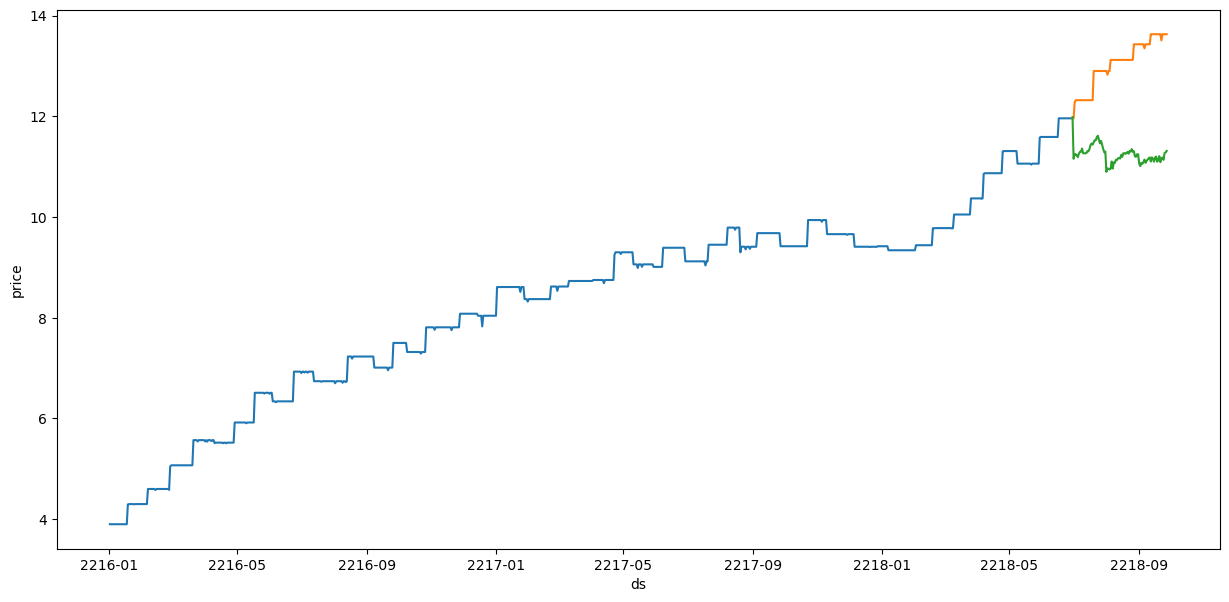

In [109]:
plt.figure(figsize=(15,7))
sns.lineplot(data = grouped_transactions[0][:910], y = grouped_transactions[0][:910]['price'], x = grouped_transactions[0][:910]['ds'])
sns.lineplot(data = grouped_transactions[0][910:], y = grouped_transactions[0][910:]['price'], x = grouped_transactions[0][910:]['ds'])
sns.lineplot(data = pred, y = pred['price'], x = pred['ds'])

In [110]:
mean_absolute_percentage_error(pred['price'], test_df_y)

0.16075573076608157

Качество получилось хуже, чем у всех представленных выше моделей. Возможно, мной было сделано что-то не так и на самом деле бустинг мог выдать результаты сильно лучше, но пока получаем только это. Видно на графике, что тренд не учтён, сезонность, думаю, тоже.

# 5. Обучение моделей <a class = 'anchor' id = 'learn_models'></a>

По итогу, для всех предсказаний я буду использовать AutoArima с включенной сезонностью.

Для рядов себестоимости товаров, кол-ва и цены конкурентов нужно будет провести анализ на тренд и сезонность.

In [111]:
def get_autoarima(train, exog_train = [], exog_predict = []):
    cols = list(train.select_dtypes(include=['float64']).columns)[0]
    log_train = pd.DataFrame(np.log10(train[cols]))
    
    log_train = pd.concat([log_train, train['date']], axis=1)
    log_train = log_train.merge(grouped_transactions[0]['date'], on='date', how = 'right')
    log_train.index = log_train['date']
    log_train.drop(columns={'date'}, inplace=True)
    log_train[cols].fillna(method = 'ffill', inplace=True)
    log_train.dropna(inplace=True)
    
    if(exog_train == [] or exog_predict == []):
        model = pm.auto_arima(log_train, m=7, seasonal=True, with_intercept=True)
        model.fit(log_train)
    else:
        model = pm.auto_arima(log_train, X = exog_train, m=7, seasonal=True, with_intercept=True)
        model.fit(log_train, X = exog_predict)
        
    forecast = model.predict(n_periods=predictions)
    
    for i in range(len(forecast)):
        forecast[i] = 10**forecast[i]
    
    output_res(pd.DataFrame(forecast), train)
    
    return pd.DataFrame(forecast)

def output_res(predicted, train):
    plt.figure(figsize=(13,5))
    col_pr = list(train.select_dtypes(include=['float64']).columns)[0]
    #train.reset_index(inplace=True)
    ax = sns.lineplot(data = train, x = train['date'], y = train[col_pr], label = 'train')
    predicted.reset_index(inplace=True)
    predicted.rename(columns={'index':'date', 0:'predicted_value'}, inplace=True)
    print(predicted)
    ax = sns.lineplot(data = predicted, x = predicted['date'], y = predicted['predicted_value'], label = 'predicted')
    ax.set (xlabel='date', ylabel='price')
    plt.show()

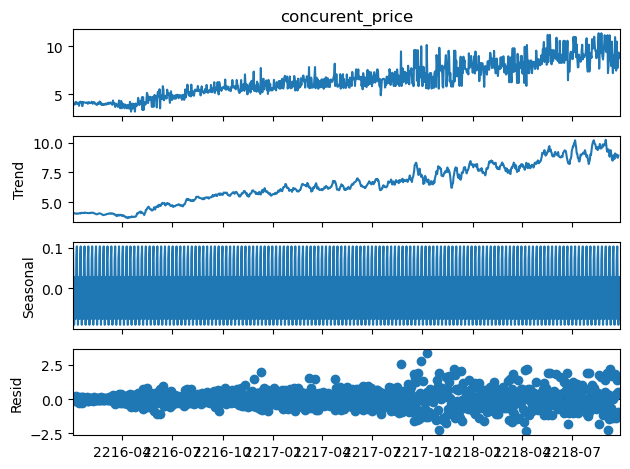

In [112]:
sd = seasonal_decompose(grouped_competitors[0]['concurent_price'])
sd.plot();

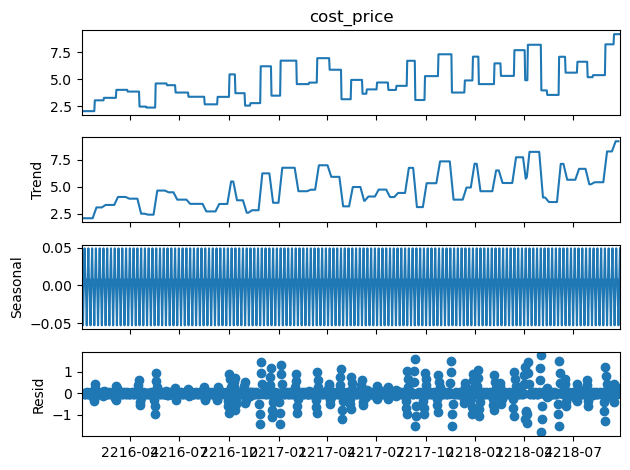

In [113]:
for i in range(15):
    #grouped_cost[i].drop(columns={'place', 'product'}, inplace = True)
    grouped_cost[i].reset_index(inplace=True)
    grouped_cost[i].rename(columns={'date':'ds'}, inplace=True)
    grouped_cost[i] = grouped_cost[i].merge(grouped_transactions[0]['ds'], on='ds', how = 'right')
    grouped_cost[i].index = grouped_cost[i]['ds']
    grouped_cost[i].drop(columns={'ds'}, inplace=True)
    grouped_cost[i]['cost_price'].fillna(method = 'ffill', inplace=True)
    
sd = seasonal_decompose(grouped_cost[0]['cost_price'])
sd.plot();

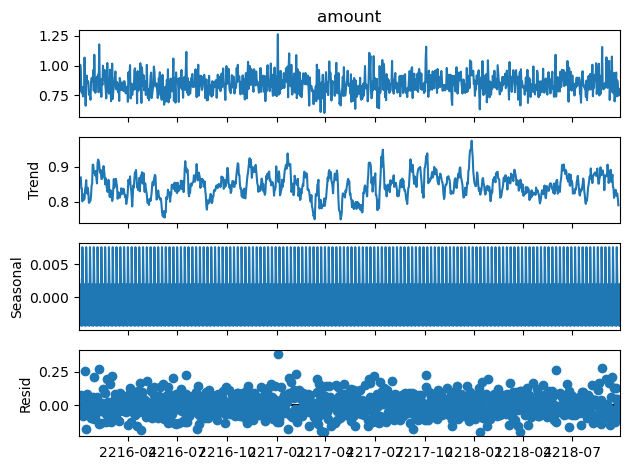

In [114]:
for i in range(15):
    grouped_transactions[i].drop(columns={'ds'}, inplace = True)
    grouped_transactions[i].reset_index(inplace=True)
    grouped_transactions[i].index = grouped_transactions[i]['date']
    grouped_transactions[i].drop(columns={'date'}, inplace=True)
    
sd = seasonal_decompose(grouped_transactions[0]['amount'])
sd.plot();

In [117]:
#окончательная подготовка датасетов для подачи в модель
grouped_prices = []
grouped_amounts = []

for i in range(len(grouped_cost)):
    grouped_transactions[i].reset_index(inplace=True)
    grouped_prices.append(pd.DataFrame(grouped_transactions[i][['price', 'date']]))
    grouped_amounts.append(pd.DataFrame(grouped_transactions[i][['amount', 'date']]))
    grouped_competitors[i].reset_index(inplace=True)

         date  predicted_value
0  2218-09-28       9.04909091
1  2218-09-29       9.05632342
2  2218-09-30       9.06356172
3  2218-10-01       9.07080580
4  2218-10-02       9.07805567
..        ...              ...
85 2218-12-22       9.68495536
86 2218-12-23       9.69269609
87 2218-12-24       9.70044301
88 2218-12-25       9.70819612
89 2218-12-26       9.71595542

[90 rows x 2 columns]


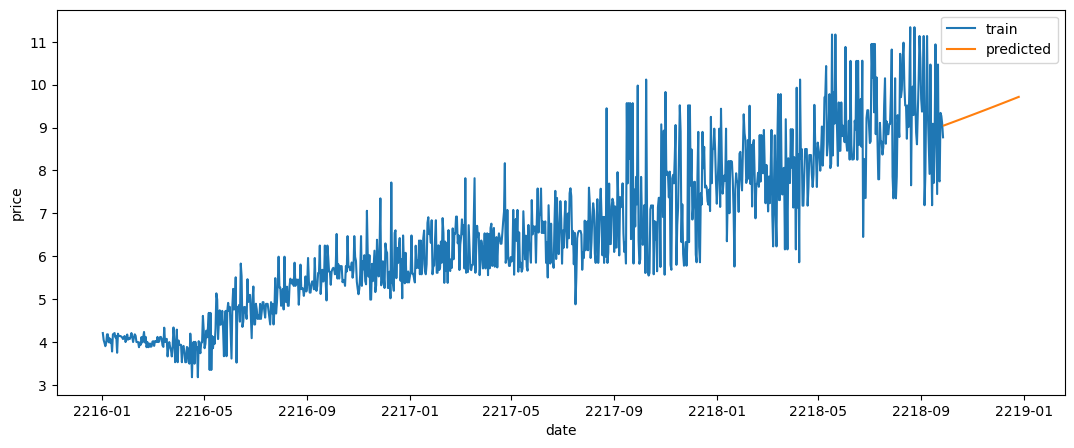

         date  predicted_value
0  2218-09-28      19.57067560
1  2218-09-29      19.12569536
2  2218-09-30      18.95997649
3  2218-10-01      19.42455469
4  2218-10-02      19.24839172
..        ...              ...
85 2218-12-22      20.42520268
86 2218-12-23      20.43988980
87 2218-12-24      20.45458749
88 2218-12-25      20.46929574
89 2218-12-26      20.48401457

[90 rows x 2 columns]


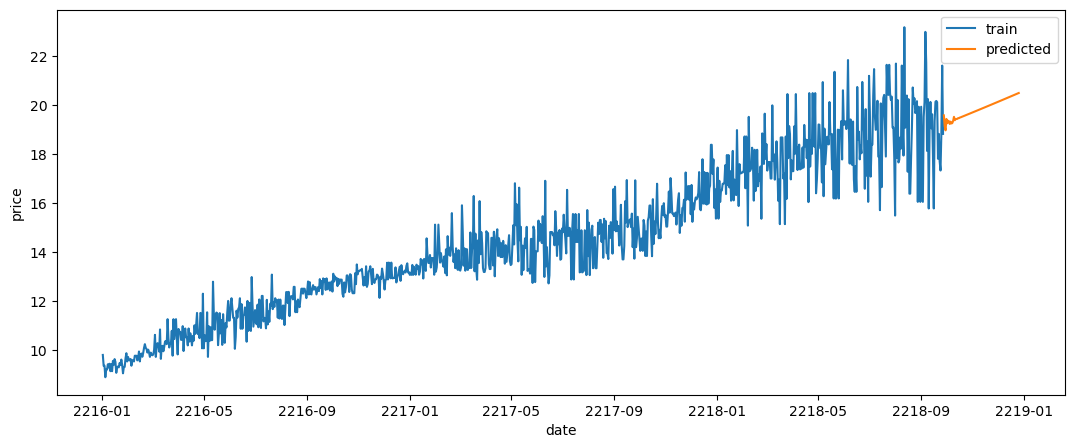

ValueError: Input contains NaN.

In [126]:
forecast_costs = []
forecast_competitors = []
forecast_prices = []

for i in range(len(grouped_cost)):
    forecast_competitors.append(get_autoarima(grouped_competitors[i]))

# Посмотреть, что c grouped_competitors[2]!!!

         date  predicted_value
0  2218-09-28      15.94825347
1  2218-09-29      15.95926112
2  2218-09-30      15.97027638
3  2218-10-01      15.98129924
4  2218-10-02      15.99232970
..        ...              ...
85 2218-12-22      16.91155314
86 2218-12-23      16.92322567
87 2218-12-24      16.93490627
88 2218-12-25      16.94659492
89 2218-12-26      16.95829165

[90 rows x 2 columns]


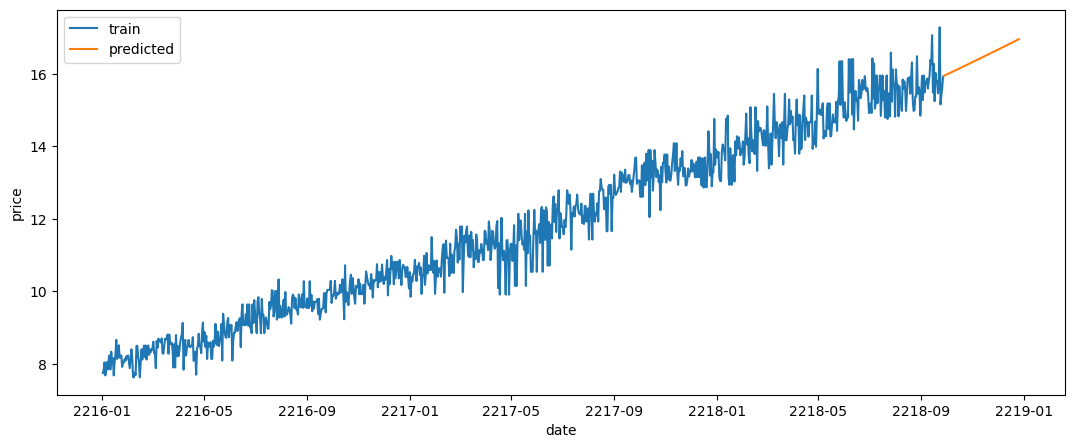

,0
2218-09-28,15.94825347
2218-09-29,15.95926112
2218-09-30,15.97027638
2218-10-01,15.98129924
2218-10-02,15.99232970
...,...
2218-12-22,16.91155314
2218-12-23,16.92322567
2218-12-24,16.93490627
2218-12-25,16.94659492


In [129]:
get_autoarima(grouped_competitors[3])

In [132]:
grouped_competitors[0]

,date,concurent_price
0,2216-01-02,4.21000000
1,2216-01-03,4.04666667
2,2216-01-04,3.98000000
3,2216-01-05,3.90333333
4,2216-01-06,3.98000000
...,...,...
995,2218-09-23,7.74500000
996,2218-09-24,9.34250000
997,2218-09-25,9.27000000
998,2218-09-26,9.08666667
